In [1]:
# BiLSTM-based Intrusion Detection on TON IoT Dataset (Rewritten)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split

# Load Dataset
df = pd.read_csv('../dataset/full_df_30.csv', low_memory=False)
print("Original DataFrame Head:\n", df.head())
print("\nOriginal Class Distribution:\n", df['type'].value_counts())
print("\nOriginal Label Distribution:\n", df['label'].value_counts())
print("\nOriginal Data Types:\n", df.dtypes)
print("\nOriginal Data Shapes:\n", df.shape)

# --- Data Preprocessing ---
# Clean and impute
df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce').fillna(0)
df.drop_duplicates(inplace=True)

df.fillna(df.mean(numeric_only=True), inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True) # Or df[col].mode()[0]
        else:
            df[col].fillna(df[col].mean(), inplace=True)

print(f"Shape after handling NaNs: {df.shape}")

# Identify targets
TARGET_LABEL = 'label'
TARGET_TYPE = 'type'

# Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if TARGET_TYPE in categorical_cols:
    categorical_cols.remove(TARGET_TYPE)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded column: {col}")

# Normalize numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if TARGET_LABEL in numerical_cols:
    numerical_cols.remove(TARGET_LABEL)

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

binary_y = df[TARGET_LABEL].values
type_encoder = LabelEncoder()
y_multiclass_encoded = type_encoder.fit_transform(df[TARGET_TYPE])
num_classes = len(le.classes_)
# Convert to one-hot encoding for Keras if using categorical_crossentropy
y_multiclass_onehot = to_categorical(y_multiclass_encoded)

y_multiclass_labels = np.argmax(y_multiclass_onehot, axis=1)

# Drop targets from features
X = df.drop(columns=[TARGET_LABEL, TARGET_TYPE]).values
print("Feature shape (flat):", X.shape)
print("Binary target shape:", binary_y.shape)
print("Multi-class target shape:", y_multiclass_labels.shape)

# print the class distribution of binary_y and y_multiclass_labels
print("Binary target class distribution:")
print(Counter(binary_y))
print("Multi-class target class distribution:")
print(Counter(y_multiclass_labels))

2025-10-29 21:42:17.484543: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 21:42:17.525796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 21:42:18.521718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Original DataFrame Head:
            ts         src_ip  src_port        dst_ip  dst_port proto service  \
0  1556499101  192.168.1.193     60396  192.168.1.33      8080   tcp       -   
1  1556494424  192.168.1.193     59273  192.168.1.33      8080   tcp       -   
2  1556487945  192.168.1.193     57717  192.168.1.33      8080   tcp       -   
3  1556508616  192.168.1.193     62682  192.168.1.33        80   tcp       -   
4  1556511697  192.168.1.193     63419  192.168.1.33      8080   tcp       -   

   duration src_bytes  dst_bytes  ... http_response_body_len  \
0  0.000180         0          0  ...                      0   
1  0.000111         0          0  ...                      0   
2  0.000148         0          0  ...                      0   
3  0.000127         0          0  ...                      0   
4  0.000122         0          0  ...                      0   

   http_status_code  http_user_agent  http_orig_mime_types  \
0                 0                -          

In [2]:
# 1. Split BEFORE SMOTE (to avoid leakage)
# ----------------------------------------
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X,
    y_multiclass_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass_encoded  # stratify on binary for this example
)

# Reset indices
X_train = pd.DataFrame(X_train).reset_index(drop=True).values
X_test = pd.DataFrame(X_test).reset_index(drop=True).values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_multiclass labels shape: {y_train_multi.shape}")
print(f"X_test  shape: {X_test.shape}")
print(f"y_test_multiclass labels shape: {y_test_multi.shape}")

# print the class distribution of binary_y and y_multiclass
# print the class distribution of binary_y and y_multiclass
print("Multi-class target class distribution (train):")
print(Counter(np.argmax(y_train_multi, axis=1)))
print("Multi-class target class distribution (test):")
print(Counter(np.argmax(y_test_multi, axis=1)))

# scaling the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Scaling complete.")


X_train shape: (408834, 44)
y_train_multiclass labels shape: (408834, 9)
X_test  shape: (102209, 44)
y_test_multiclass labels shape: (102209, 9)
Multi-class target class distribution (train):
Counter({np.int64(5): 240000, np.int64(1): 24000, np.int64(8): 24000, np.int64(2): 24000, np.int64(7): 24000, np.int64(0): 24000, np.int64(6): 24000, np.int64(3): 24000, np.int64(4): 834})
Multi-class target class distribution (test):
Counter({np.int64(5): 60000, np.int64(3): 6000, np.int64(2): 6000, np.int64(1): 6000, np.int64(8): 6000, np.int64(7): 6000, np.int64(0): 6000, np.int64(6): 6000, np.int64(4): 209})
Scaling complete.


In [3]:
# --- Create Sequences ---
def create_sequences(
    X,
    y,
    window_size: int = 10,
    debug: bool = False,
    trace_limit: int = 5
):
    # Convert to numpy if not already
    X = np.asarray(X)
    y = np.asarray(y)

    # Input validation
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples")
    if len(X.shape) != 2:
        raise ValueError("X must be a 2D array: (samples, features)")
    if len(y.shape) > 2:
        raise ValueError("y must be a 1D or 2D array")

    X_seq, y_seq = [], []
    total = len(X) - window_size + 1
    if debug:
        print(f"Total samples: {len(X)} | Generating {total} sequences (window_size={window_size})")

    for i in range(total):
        window = X[i : i + window_size]
        label = y[i + window_size - 1]
        X_seq.append(window)
        y_seq.append(label)

        if debug and i < trace_limit:
            print(f"\n--- Seq {i+1}/{total} ---")
            print(f"  X indices: {i} to {i+window_size-1}")
            print(f"  y index:   {i+window_size-1} → label={label}")
            print(f"  window.shape: {window.shape}")

    if debug:
        print(f"\nTotal sequences generated: {len(X_seq)}")

    return np.array(X_seq), np.array(y_seq)


TIMESTEPS = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train_multi, window_size=TIMESTEPS, debug=True)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_multi, window_size=TIMESTEPS, debug=True)


print("Train sequence shape:", X_train_seq.shape)  # (samples, timesteps, features)
print("Test sequence shape:", X_test_seq.shape)
print("multi target distribution:", Counter(np.argmax(y_train_multi, axis=1)))

# counters
print("Class distribution in y_train_seq:", Counter(np.argmax(y_train_seq, axis=1)))
print("Class distribution in y_test_seq:", Counter(np.argmax(y_test_seq, axis=1)))


Total samples: 408834 | Generating 408825 sequences (window_size=10)

--- Seq 1/408825 ---
  X indices: 0 to 9
  y index:   9 → label=[0. 0. 0. 0. 0. 0. 0. 0. 1.]
  window.shape: (10, 44)

--- Seq 2/408825 ---
  X indices: 1 to 10
  y index:   10 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (10, 44)

--- Seq 3/408825 ---
  X indices: 2 to 11
  y index:   11 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (10, 44)

--- Seq 4/408825 ---
  X indices: 3 to 12
  y index:   12 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (10, 44)

--- Seq 5/408825 ---
  X indices: 4 to 13
  y index:   13 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (10, 44)

Total sequences generated: 408825
Total samples: 102209 | Generating 102200 sequences (window_size=10)

--- Seq 1/102200 ---
  X indices: 0 to 9
  y index:   9 → label=[0. 0. 0. 0. 0. 1. 0. 0. 0.]
  window.shape: (10, 44)

--- Seq 2/102200 ---
  X indices: 1 to 10
  y index:   10 → label=[0. 0. 0. 0. 0. 0. 0. 1. 0.]
  window.

In [8]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Convert one-hot to integer labels for y_train_seq
y_train_seq_labels = np.argmax(y_train_seq, axis=1)

# Apply ADASYN instead of SMOTE
adasyn = ADASYN(
    sampling_strategy={4: 10000},  # Only oversample class 4
    random_state=42,
    n_neighbors=5
)
X_train_res, y_train_res = adasyn.fit_resample(
	X_train_seq.reshape(X_train_seq.shape[0], -1),  # Flatten for ADASYN
	y_train_seq_labels
)
X_train_res = X_train_res.reshape(X_train_res.shape[0], TIMESTEPS, X_train_seq.shape[2])  # Reshape back to sequences
y_train_res = to_categorical(y_train_res, num_classes=y_train_seq.shape[1])  # One-hot encode	
print("After ADASYN:")
print("Resampled X_train shape:", X_train_res.shape)
print("Resampled y_train shape:", y_train_res.shape)
print("Resampled class distribution:", Counter(np.argmax(y_train_res, axis=1)))

After ADASYN:
Resampled X_train shape: (417905, 10, 44)
Resampled y_train shape: (417905, 9)
Resampled class distribution: Counter({np.int64(5): 239992, np.int64(8): 24000, np.int64(2): 24000, np.int64(7): 24000, np.int64(0): 24000, np.int64(6): 24000, np.int64(3): 24000, np.int64(1): 23999, np.int64(4): 9914})


In [9]:
from sklearn.utils import shuffle

# Without SMOTE X_train_seq, y_train_seq
# X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_seq, y_train_seq, random_state=42)

# SMOTE on X_train_res, y_train_res
X_train_seq_bal_shuffle, y_train_seq_bal_shuffle = shuffle(X_train_res, y_train_res, random_state=42)

val_fraction = 0.2
n_total = X_train_seq_bal_shuffle.shape[0]
n_val = int(n_total * val_fraction)

X_val_seq = X_train_seq_bal_shuffle[-n_val:]
y_val_seq = y_train_seq_bal_shuffle[-n_val:]
X_train_seq_final = X_train_seq_bal_shuffle[:-n_val]
y_train_seq_final = y_train_seq_bal_shuffle[:-n_val]

print("Final training shapes:")
print(f"X_train_seq_final shape: {X_train_seq_final.shape}")
print(f"y_train_seq_final shape: {y_train_seq_final.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print("Final training label distributions:")
print(f"y_train_seq_final distribution: {Counter(np.argmax(y_train_seq_final, axis=1))}")
print(f"y_val_seq distribution: {Counter(np.argmax(y_val_seq, axis=1))}")

Final training shapes:
X_train_seq_final shape: (334324, 10, 44)
y_train_seq_final shape: (334324, 9)
X_val_seq shape: (83581, 10, 44)
y_val_seq shape: (83581, 9)
Final training label distributions:
y_train_seq_final distribution: Counter({np.int64(5): 192171, np.int64(2): 19243, np.int64(3): 19219, np.int64(0): 19205, np.int64(6): 19170, np.int64(1): 19153, np.int64(8): 19139, np.int64(7): 19130, np.int64(4): 7894})
y_val_seq distribution: Counter({np.int64(5): 47821, np.int64(7): 4870, np.int64(8): 4861, np.int64(1): 4846, np.int64(6): 4830, np.int64(0): 4795, np.int64(3): 4781, np.int64(2): 4757, np.int64(4): 2020})


In [10]:
from tensorflow.keras.metrics import Metric

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        # Clip predictions to prevent log(0) error
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        # Compute cross-entropy per class
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return loss

class GMeanMetric(Metric):
    def __init__(self, name='gmean', **kwargs):
        super(GMeanMetric, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)

        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, y_pred), tf.equal(y_true, 1)), tf.float32))
        tn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, y_pred), tf.equal(y_true, 0)), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred), tf.equal(y_true, 0)), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(y_true, y_pred), tf.equal(y_true, 1)), tf.float32))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        sensitivity = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        return tf.sqrt(sensitivity * specificity)

    def reset_states(self):
        for var in self.variables:
            var.assign(0)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, AUC
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score, classification_report, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts


# Model definition
model = Sequential([
    Bidirectional(LSTM(
        128,                       
        return_sequences=True,
        recurrent_dropout=0.15,
        recurrent_activation='sigmoid',
        activation='tanh',
        kernel_regularizer=l2(1e-5)
    ), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(
        64,
        recurrent_dropout=0.15,
        recurrent_activation='sigmoid', 
        activation='tanh',
        kernel_regularizer=l2(1e-5)
    )),
    LayerNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.25),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(9, activation='softmax')
])

model.summary()

lr_schedule = CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=5)
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', AUC(name='auc'), Recall(), Precision(), GMeanMetric()]
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate after 2 epochs of no improvement
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,        # Usually, LR reduction has a lower patience than early stopping
    min_lr=1e-6,
    verbose=1
)

frequencies = np.sum(y_train_seq_final, axis=0)
median_freq = np.median(frequencies)
class_weights = {cls: median_freq / count for cls, count in enumerate(frequencies)}

# print("Class weights for training:", class_weights)

# Train
history = model.fit(
    X_train_seq_final, y_train_seq_final,
    validation_data=(X_val_seq, y_val_seq),
    epochs=10,
    batch_size=128,
    shuffle=True,
    callbacks=[early_stopping],
    class_weight=class_weights,
    verbose=1
)

results = model.evaluate(X_test_seq, y_test_seq, verbose=2)

print("Test Loss: {}".format(results[0]))
print("Test Accuracy: {}".format(results[1]))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 10, 256)        │       177,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 10, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,905 (1.35 MB)

 Trainable params: 352,905 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 125s 45ms/step - accuracy: 0.7494 - auc: 0.9671 - gmean: 0.6593 - loss: 0.0591 - precision_1: 0.8919 - recall_1: 0.6098 - val_accuracy: 0.9064 - val_auc: 0.9935 - val_gmean: 0.9363 - val_loss: 0.0367 - val_precision_1: 0.9376 - val_recall_1: 0.8699
Epoch 2/10
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 117s 45ms/step - accuracy: 0.8927 - auc: 0.9932 - gmean: 0.8888 - loss: 0.0205 - precision_1: 0.9255 - recall_1: 0.8432 - val_accuracy: 0.9316 - val_auc: 0.9967 - val_gmean: 0.9308 - val_loss: 0.0229 - val_precision_1: 0.9451 - val_recall_1: 0.9162
Epoch 3/10
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 117s 45ms/step - accuracy: 0.9149 - auc: 0.9954 - gmean: 0.9089 - loss: 0.0157 - precision_1: 0.9364 - recall_1: 0.8820 - val_accuracy: 0.9557 - val_auc: 0.9984 - val_gmean: 0.9766 - val_loss: 0.0149 - val_precision_1: 0.9626 - val_recall_1: 0.9462
Epoch 4/10
2612/2612 ━━━━━━━━━━━━━━━━━━━━ 118s 45ms/step - accuracy: 0.9401 - auc: 0.9974 - gmean: 0.9318 - loss: 0.0114 - prec

['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password' 'scanning'
 'xss']
Encoded class 0 -> backdoor
Encoded class 1 -> ddos
Encoded class 2 -> dos
Encoded class 3 -> injection
Encoded class 4 -> mitm
Encoded class 5 -> normal
Encoded class 6 -> password
Encoded class 7 -> scanning
Encoded class 8 -> xss
3194/3194 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6000
           1       0.95      0.99      0.97      5999
           2       0.97      0.96      0.97      5999
           3       0.96      0.99      0.98      5999
           4       0.31      0.95      0.47       209
           5       1.00      0.98      0.99     59995
           6       0.96      1.00      0.97      6000
           7       0.98      1.00      0.99      6000
           8       0.98      0.97      0.98      5999

    accuracy                           0.98    102200
   macro avg       0.90      0.98      0.92 

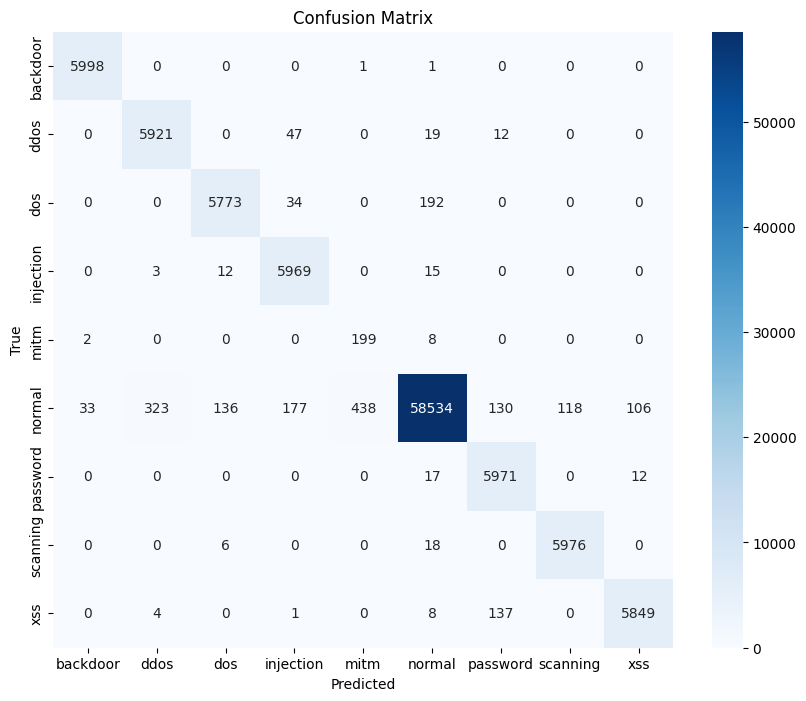

    Class      FNR      FPR
 backdoor 0.000333 0.000364
     ddos 0.013002 0.003430
      dos 0.037673 0.001601
injection 0.005001 0.002692
     mitm 0.047847 0.004304
   normal 0.024352 0.006587
 password 0.004833 0.002900
 scanning 0.004000 0.001227
      xss 0.025004 0.001227


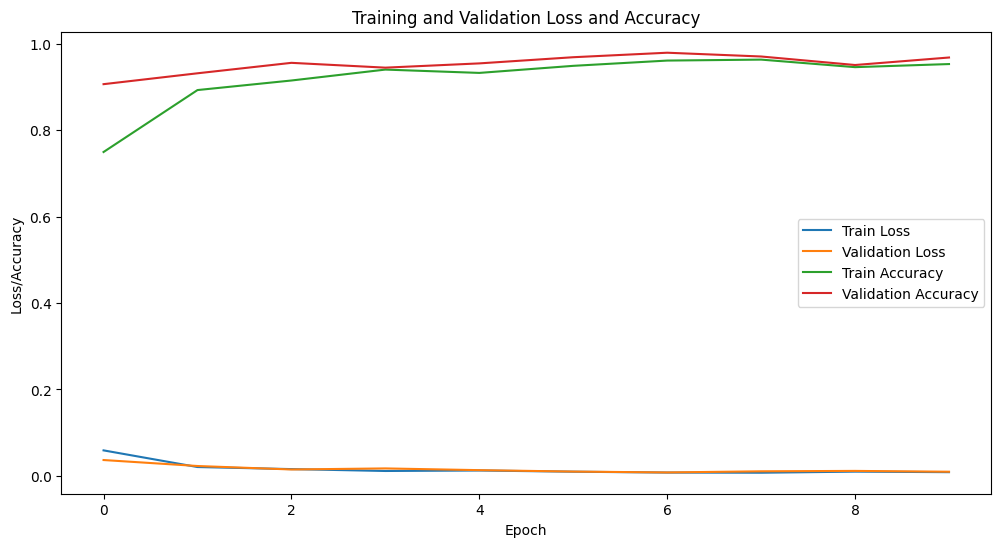

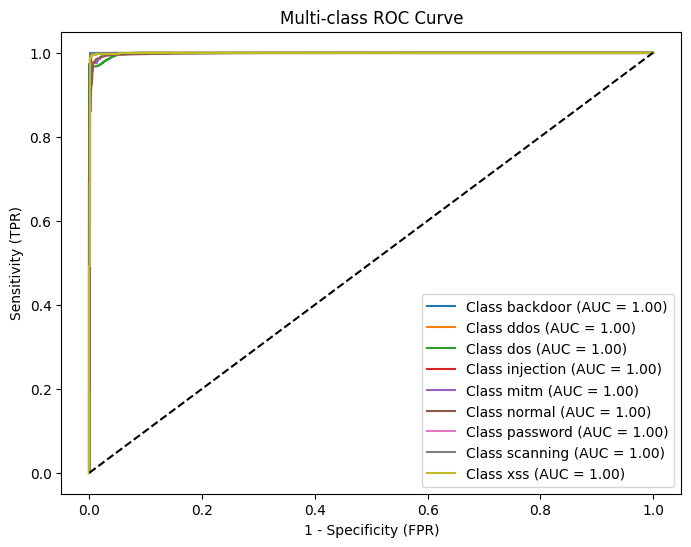

In [13]:
import seaborn as sns

# original class labels (what was in df[TARGET_TYPE])
print(type_encoder.classes_)

# numeric codes assigned
for i, cls in enumerate(type_encoder.classes_):
    print(f"Encoded class {i} -> {cls}")


# Print classification report
y_pred_probs = model.predict(X_test_seq)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test_seq.argmax(axis=1)
print(classification_report(y_true_classes, y_pred_classes))

#confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=type_encoder.classes_,
            yticklabels=type_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# For multi-class, FNR and FPR are not simply tn, fp, fn, tp.
# If you want per-class FNR/FPR:
fnr = []
fpr = []
for i in range(cm.shape[0]):
    fn = cm[i, :].sum() - cm[i, i]
    tp = cm[i, i]
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - (tp + fn + fp)
    fnr.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

results_df = pd.DataFrame({
    "Class": type_encoder.classes_,
    "FNR": fnr,
    "FPR": fpr
})

print(results_df.to_string(index=False))
# print("False Negative Rate (FNR) per class:", fnr)
# print("False Positive Rate (FPR) per class:", fpr)

# plot validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

# sensitivity vs 1-specificity plot for multi-class
plt.figure(figsize=(8, 6))
for i in range(len(type_encoder.classes_)):
    fpr_i, tpr_i, _ = roc_curve(y_test_seq[:, i], y_pred_probs[:, i])
    plt.plot(fpr_i, tpr_i, label=f'Class {type_encoder.classes_[i]} (AUC = {roc_auc_score(y_test_seq[:, i], y_pred_probs[:, i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('Multi-class ROC Curve')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.legend()
plt.show()  


KeyError: 'precision'

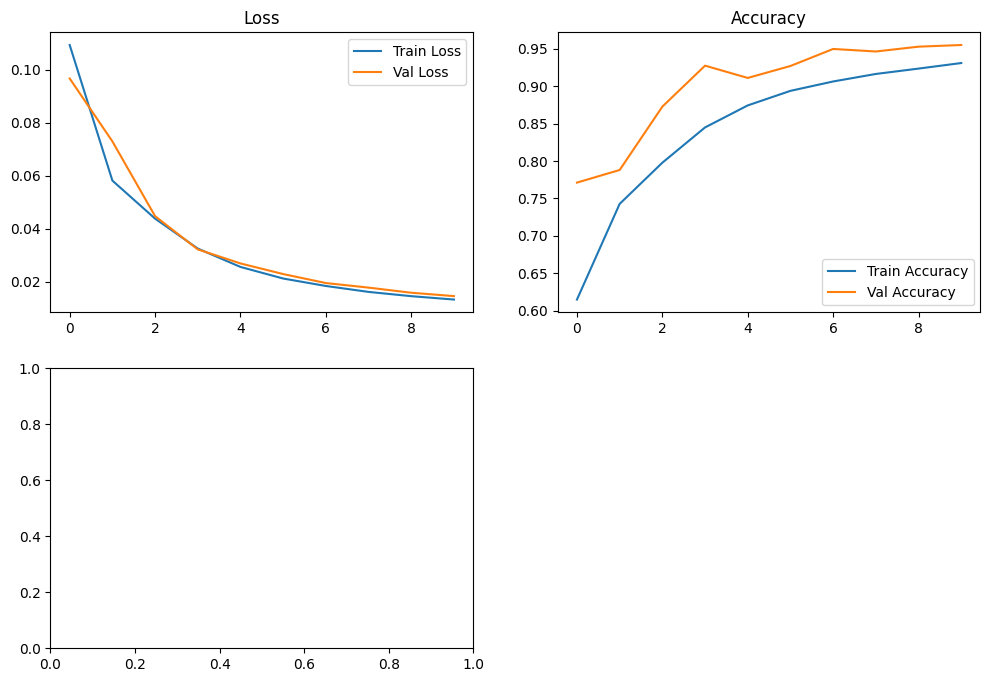

In [ ]:
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot Precision & Recall
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Precision & Recall')
plt.legend()

# Plot G-Mean
plt.subplot(2, 2, 4)
plt.plot(history.history['val_gmean'], label='Val G-Mean', color='green')
plt.title('Validation G-Mean')
plt.legend()

plt.tight_layout()
plt.show()
